# Qiskit

Qiskit - IBM library for quantum developers. This is how we install.

In [ ]:
!pip install qiskit

It consists of [few parts](https://github.com/orgs/Qiskit/repositories). Among them are:
- [Terra](https://qiskit.org/documentation/apidoc/terra.html) - basic quantum components.
- [Aer](https://qiskit.org/documentation/apidoc/aer.html) - simulators. You can run a program in multiple ways.
- [Ignis](https://qiskit.org/documentation/apidoc/ignis.html) - hardware verification and error correction.
- [Nature](https://github.com/Qiskit/qiskit-nature) - scientific task solvers.
- [Optimization](https://github.com/Qiskit/qiskit-optimization) - optimizers.
- [Machine Learning](https://github.com/Qiskit/qiskit-machine-learning) - few ML algorithms.
- [Metal](https://github.com/Qiskit/qiskit-metal) - supercoductive circuits developer toolkit.

Also there are separate finance, chemisty blocks.

Simplest simulated circuit looks like ...

In [1]:
# these are classes to initialize registers
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
# visualization code
from qiskit.visualization import plot_histogram

qr = QuantumRegister(2, 'qbits')
cr = ClassicalRegister(2, 'bits')
qc = QuantumCircuit(qr, cr)

No operations, empty circuit

In [2]:
qc.draw()

qbits_0: 
         
qbits_1: 
         
 bits: 2/

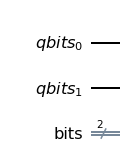

In [3]:
# also with latex
# qc.draw(output='latex')

# with matplotlib
import matplotlib.pyplot as plt
qc.draw(output='mpl')
plt.show()

Let's add 2 gates. $0^{th}$ qubit with get $H$ (Hadamard), and then, we apply $CNOT$ to both, with 0 -- controlling, and 1 -- controlled.

In [4]:
qc.h(qr[0])
qc.cx(qr[0], qr[1])

# also this works
# qc.h(0)
# qc.cx(0, 1)

Draw it with matplotlib now

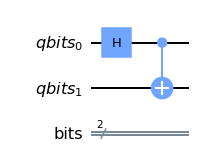

In [5]:
qc.draw(output='mpl')
plt.show()

What about measuring?

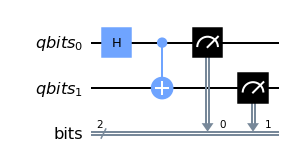

In [6]:
# qc.measure(qr[0], cr[0])
# qc.measure(qr[1], cr[1])
# or even simpler
qc.measure(qr, cr)

qc.draw(output='mpl')
plt.show()

This picture is indeed a quantum program. The only think left is to execute!

There are many simulators, each of them have its own features. Deeper here: https://qiskit.org/documentation/tutorials/simulators/1_aer_provider.html

First, we run probabilistic `qasm_simulator`, which has an opportunity to add noise. Do it 1000 times.

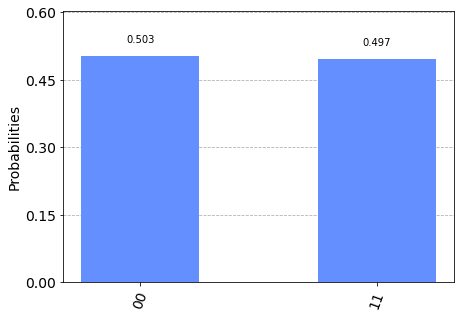

In [7]:
from qiskit import execute, Aer

job = execute(qc, Aer.get_backend('qasm_simulator'), shots=1000)
counts = job.result().get_counts(qc)

plot_histogram(counts)
plt.show()

# TBD - errors
I have no idea how to model decoherence errors. Maybe we shold thy this
https://qiskit.org/documentation/tutorials/noise/2_relaxation_and_decoherence.html

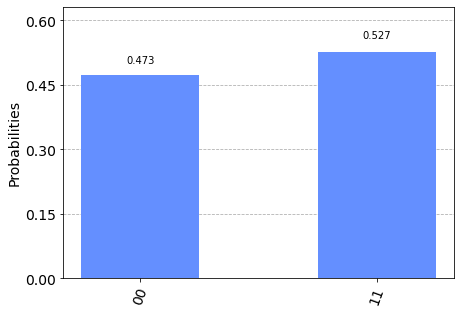

In [148]:
from qiskit.providers.aer import noise

# from example https://qiskit.org/documentation/stubs/qiskit.providers.aer.noise.NoiseModel.html
noise_model = noise.NoiseModel()

import numpy as np
rot = np.array([[0.9, -0.4358898943540673552237], [0.4358898943540673552237, 0.9]], dtype=np.float64)
unitary_error = np.kron(rot, rot)
# 1-qubit gates
error_1 = noise.mixed_unitary_error([(rot.T, 1.0)])
noise_model.add_all_qubit_quantum_error(error_1, ['h'])

# 2-qubit gates
error_2 = noise.mixed_unitary_error([(unitary_error, 1.0)])
noise_model.add_all_qubit_quantum_error(error_2, ['cx'])

backend = Aer.get_backend('qasm_simulator', noise_model=noise_model)
job = execute(qc, backend, shots=1000)
counts = job.result().get_counts(qc)

plot_histogram(counts)
plt.show()

And here is ideal vector state simulator. It runs once, but gives different results!

[0.+0.j 0.+0.j 0.+0.j 1.+0.j]


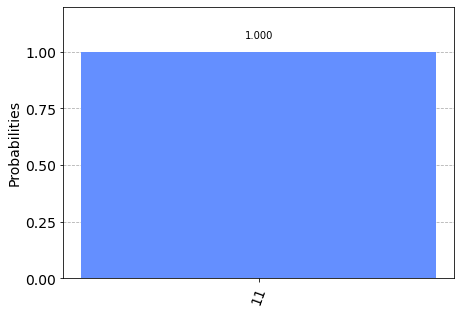

In [8]:
job = execute(qc, Aer.get_backend('statevector_simulator'))
result = job.result()
counts = result.get_counts(qc)

print(result.get_statevector(qc))
plot_histogram(counts)
plt.show()

And finally unitary matrix simulator. As measurements are not unitary, we will collect the same ciruit without measurements.

In [9]:
qru = QuantumRegister(2, 'qbits')
cru = ClassicalRegister(2, 'bits')
qcu = QuantumCircuit(qru, cru)

qcu.h(qru[0])
qcu.cx(qru[0], qru[1])

backend = Aer.get_backend('unitary_simulator')
job = backend.run(qcu)
result = job.result()

# Show the results
print(result.get_unitary(qcu, decimals=3))

[[ 0.707+0.j  0.707-0.j  0.   +0.j  0.   +0.j]
 [ 0.   +0.j  0.   +0.j  0.707+0.j -0.707+0.j]
 [ 0.   +0.j  0.   +0.j  0.707+0.j  0.707-0.j]
 [ 0.707+0.j -0.707+0.j  0.   +0.j  0.   +0.j]]


# Real QPU

But the coolest is to run in real QPU, yes?

Visit https://quantum-computing.ibm.com/account and get the key!

In [10]:
from qiskit import IBMQ
IBMQ.save_account(
    '...'
)

configrc.store_credentials:WARNING:2021-10-12 14:57:51,947: Credentials already present. Set overwrite=True to overwrite.


In [11]:
IBMQ.load_account()
provider = IBMQ.get_provider('ibm-q')

In [18]:
available_cloud_backends = provider.backends() 
for backend in available_cloud_backends:
    status = backend.status()
    is_operational = status.operational
    jobs_in_queue = status.pending_jobs
    print(f"{backend}\t is online={is_operational}\twith a queue={jobs_in_queue}")

ibmq_qasm_simulator	 is online=True	with a queue=3
ibmq_armonk	 is online=True	with a queue=3
ibmq_santiago	 is online=True	with a queue=1245
ibmq_bogota	 is online=True	with a queue=2
ibmq_lima	 is online=True	with a queue=3
ibmq_belem	 is online=True	with a queue=1
ibmq_quito	 is online=True	with a queue=31
simulator_statevector	 is online=True	with a queue=3
simulator_mps	 is online=True	with a queue=3
simulator_extended_stabilizer	 is online=True	with a queue=2
simulator_stabilizer	 is online=True	with a queue=2
ibmq_manila	 is online=True	with a queue=6


Match these providers with https://quantum-computing.ibm.com/services?services=systems

In [19]:
qpu = provider.get_backend("ibmq_belem")
job = execute(qc, backend=qpu)

In [16]:
from qiskit.tools.monitor import job_monitor
from time import time

start = time()
job_monitor(job)
end = time()

print(f"Time in a queue: {end - start:.2f} s")

Job Status: job has successfully run
Time in a queue: 11.02 s


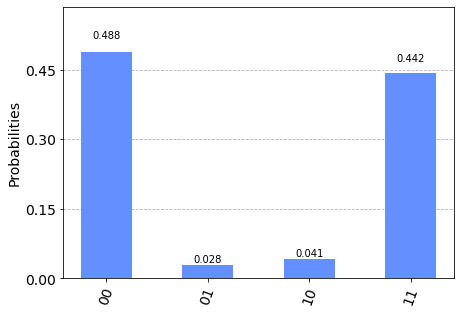

In [17]:
counts = job.result().get_counts()
plot_histogram(counts)
plt.show()